<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/%EC%96%B8%EC%96%B4%EC%A7%80%EB%8A%A5(%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4_NLP)/ex04_NER(%EA%B0%9C%EC%B2%B4%EB%AA%85%EC%9D%B8%EC%8B%9D%2C%EB%B6%84%EB%A5%98)_%EB%8B%A4%EC%A4%91%EA%B0%90%EC%A0%95%EB%B6%84%EB%A5%98_%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8%EA%B5%AC%EC%B6%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ex04_NER(개체명인식,분류)_다중감정분류_파이프라인구축
# 환경세팅
# - gpu: A100
# 드라이브 연동
# (상대경로) 작업 폴더 이동
%cd /content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)

/content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)


# 목표
- 다중 감정 분류 모델 Fine-Tuning: 커스텀 데이터에 맞춰서 학습 시키기
- 개체명 인식(분류) 모델 Fine-Tuning: 커스텀 데이터에 대해서 맞춰서 학습 시키기
- 두 모델 예측 결과를 결합 -> 특정 개체(ex.브랜드별) 감정 통계를 분석할 수 있는 통합 파이프라인 구축

- ex) "나는 LG OLED TV를 사고 싶다." -> 브랜드명:LG , 제품명: OLED TV

## 시나리오

### 배경
- “브랜드스코프”는 <u>월간 **100만 건** 이상의 소셜 미디어 게시글</u>에 언급된 브랜드 감성을 분석하는 AI 플랫폼  
- AI Hub의 감성 대화 말뭉치(<u>**27만 문장**</u>)와 네이버×창원대 NER 데이터셋(<u>**9만 문장**</u>)을 활용하여  
  - <u>**다중 감정 분류**</u> 모델과 <u>**개체명 인식**</u> 모델을 파인튜닝  
  - 특정 브랜드별로 감정 통계를 집계하는 <u>**통합 분석 파이프라인**</u> 구축 필요  

```python
# 주요 이해관계자
- NLP 연구팀        : 감정 분류·NER 모델 파인튜닝 수행  
- 데이터 엔지니어팀  : AI Hub·Korpora 데이터 전처리 및 파이프라인 구현  
- 플랫폼 운영팀      : A100 GPU 환경에서 모델 배포·실시간 분석 서비스 운영  
- 마케팅팀          : 브랜드별 감정 통계 기반 캠페인 전략 수립  
- QA/테스트팀       : 모델 성능 검증 및 예외 사례 분석  
```

> ### 감정 분류 파트
> - AI Hub - 감성대화 말뭉치 데이터셋 활용
> - 데이터셋 링크 : https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86

---

#### AI Hub?
- AI 기술 및 제품·서비스 개발에 필요한 AI 인프라(AI 데이터, AI SW API, 컴퓨팅 자원)를 지원하는 **<U>오픈소스 AI 통합 플랫폼**</U>

---

#### 감성 대화 말뭉치 데이터셋
- **<U>약 27만 개의 문장**</U>으로 이루어진 대화 코퍼스
- 여러 연령대의 일반인 및 우울증 환자의 대화에서 추출된 문장과 그 감정 레이블(**<U>기쁨, 당황, 분노, 불안, 상처, 슬픔**</U>)로 구성

## NER(개체명 인식, Named Entity Recognition)
- 텍스트 문장에서 **<U>개체를 찾아서 미리 정의된 범주**</U>(사람 이름, 조직, 위치, 시간 , 날짜 등)으로 **<U>분류**</U>하는 자연어 처리(NLP) 방법
> ex) 문장 "올해 서울에서는 김민수 씨가 마라톤 대회에 참가했다."에서 **<U>서울은 `장소`**</U>, **<U>김민수는 `인물`**</U>로 인식


> ### 개체명 인식 파트
> - Korpora - 네이버 x 창원대 NER 데이터 활용
> - 데이터셋 링크 : https://ko-nlp.github.io/Korpora/ko-docs/corpuslist/naver_changwon_ner.html

---

#### Korpora?
- 오픈소스 말뭉치들의 다운로드와 전처리 기능을 제공하는 파이썬 라이브러리

---

#### 네이버 x 창원대 NER 데이터
- 한국어 위키백과를 텍스트 형태로 가공해 공개한 데이터
- 인물, 조직, 장소 등 다양한 개체 유형 태그가 포함되며 **<U>약 9만 개 문장**</U>으로 구성
- repository: https://github.com/naver/nlp-challenge/tree/master/missions/ner
- reference: http://air.changwon.ac.kr/?page_id=10

In [2]:
# 환경세팅
# transformers
# Korpora seqeval

!pip -q install transformers[torch] datasets

!pip -q install Korpora seqeval

# Korpora: 다양한 한국어 말뭉치(뉴스, 소설, 대화 등)을 손쉽게 다운로드/불러올 수 있는 lib
# seqeval: 개체명 인식(NER)이나 기타 시뭐스 라벨링 모델의 예측 성능(f1,precison,recall 등)
# 을 계산해주는, 평가해주는 라이브러리

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 5.1 MB/s eta 0:00:00


In [3]:
# zip 압축 해제 (bash 명령어 사용)
!unzip -q ./data/Emotional\ conversation\ corpus.zip -d ./data/Emotion\ conversation\ corpus

# ./data/Emotional\ conversation\ corpus.zip: 압축 파일 경로 (압축 해제 대상 파일),
# 공백이 포함되어 있어 \공백으로 인식
# -d ./data/Emotional\ conversation\ corpus: 'directory'의 약자, 해제된 파일을 저장할 대상 폴더를 지정

## 1.데이터셋 로드 및 준비
- 1.1)감성 대화 말뭉치 데이터셋 로드 및 준비
- 1.2)NER 데이터 로드 및 준비

- 1.1) 감성 대화 말뭉치 데이터셋 로드 및 준비

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_excel("./data/Emotion conversation corpus/Training/Source data (emotional dialogue corpus)_Training.xlsx", index_col = 0)
val_df = pd.read_excel("./data/Emotion conversation corpus/Validation/Source data (emotional dialogue corpus)_Validation.xlsx", index_col = 0)

In [6]:
# head(): 행 다섯개만 출력
train_df.head()
val_df.head()

,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
1,청년,남성,"진로,취업,직장",해당없음,불안,두려운,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,실수하시다니 정말 미안한 마음이 크겠어요.,내 능력이 부족한 거 같은데 그만 다녀야 될거같아.,능력을 올리려면 어떤 방법이 있을까요?,퇴근 후 여가에 회사 일을 더 열심히 해서 피해가 가지 않도록 해야겠어.,꼭 좋은 결과 있길 바라요.
2,청년,남성,"진로,취업,직장",해당없음,불안,두려운,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.,큰 프로젝트를 혼자 하셔서 고민이 많겠네요.,나에게 너무 크게 느껴지는 중요한 프로젝트라 버거운 느낌이 들어.,프로젝트를 잘하시기 위해서 어떤 걸 할 수 있나요?,동료 직원에게 도움을 요청해서 같이 해결해야겠어.,동료 직원에게 도움을 요청하기로 하셨군요.
3,청년,남성,"진로,취업,직장",해당없음,불안,두려운,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.,직장 상사가 무섭게 생기셔서 친해지는 게 어렵군요.,무섭게 생겼는데도 업무를 보려면 친해져야 할 것 같단말이야.,상사분과 친해질 수 있는 방법은 무엇이 있을까요?,먼저 다가가서 말을 걸어볼게.,직장 상사와 친해지시면 좋겠네요.
4,청년,남성,"진로,취업,직장",해당없음,불안,두려운,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.,첫 직장이라서 정말 떨리시고 긴장되실 것 같아요.,첫 직장이어서 잘 적응을 할 수 있을지 모르겠어.,잘 적응 하시려면 무엇을 할 수 있을까요?,직장 동료와 상사들이랑 친하게 지내야겠어.,직장에 잘 적응하시길 바라요.
5,청년,남성,"진로,취업,직장",해당없음,불안,두려운,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.,직장 사람들 관계에 대해서 고민이시군요.,내가 낯가림이 심해서 친해질 수 있을지 모르겠어.,직장 사람들과 친해지려면 무슨 방법이 있을까요?,서로 같은 취미를 공유하고 얘기를 나누다 보면 친해질 수 있을 거 같아.,직장 사람들과 좋은 관계를 가지시길 응원해요.


In [7]:
# info(): 데이터의 전체적인 정보
# 행,열 크기
# 데이터 타입
# 결측치 여부
# 선택할 컬럼명
train_df.info()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51630 entries, 1 to 51630
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연령      51630 non-null  object
 1   성별      51630 non-null  object
 2   상황키워드   51630 non-null  object
 3   신체질환    51630 non-null  object
 4   감정_대분류  51630 non-null  object
 5   감정_소분류  51630 non-null  object
 6   사람문장1   51630 non-null  object
 7   시스템문장1  51630 non-null  object
 8   사람문장2   51630 non-null  object
 9   시스템문장2  51630 non-null  object
 10  사람문장3   42695 non-null  object
 11  시스템문장3  42695 non-null  object
dtypes: object(12)
memory usage: 5.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 6641 entries, 1 to 6641
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연령      6641 non-null   object
 1   성별      6641 non-null   object
 2   상황키워드   6641 non-null   object
 3   신체질환    6641 non-null   object
 4   감정_대분류  6641 non-null   obje

In [8]:
# 감정_대분류, 사람문장1 사용 분석 이용
train_df[['감정_대분류', '사람문장1']].head(5)

,감정_대분류,사람문장1
1,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
2,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
3,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
4,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
5,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


In [9]:
# 감정 카테고리 회수 확인
# 클래스 개수
# 클래스별 데이터 건수
train_df['감정_대분류'].value_counts()

# 직장, 청소년, 인간관계 등 다양한 상황에서 분노에 해당하는 대화 예시
# 생각보다 긍정적인 카테고리는 적고, 부정적인 의미의 카테고리가 많음을 확인
# "사람문장1" 열의 문장을 입력 시퀀스로, "감정_대분류" 열의 값을 타겟 레이블로 사용하여
# 감정 분류 모델 fine tuning 수행 예정

,count
감정_대분류,
불안,9320
분노,9160
상처,9143
슬픔,9125
당황,8756
기쁨,6126


In [10]:
from transformers import AutoTokenizer
# 사용할 모델 이름 지정
model_name = "monologg/koelectra-base-v3-discriminator"

In [11]:
# 사전학습된 토크나이저 도구 로드
# koelectra
tokenizer_k = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [12]:
# 학습(train), 검증(validation) 데이터에서 텍스트와 레이블 분리
# Dataset 포멧 변경 전, 모델 학습에 적합한 형태로 다듬어 주기 위한 list 형태로 변환
X_train = list(train_df['사람문장1'])
X_val = list(val_df['사람문장1'])

y_train = list(train_df['감정_대분류'])
y_val = list(val_df['감정_대분류'])

In [13]:
# 크기 확인(길이 확인)
len(X_train), len(y_train), len(X_val), len(y_val)

(51630, 51630, 6641, 6641)

In [14]:
# 라벨 고유값 확인 (정수 ID 매핑용: 짝지어주기)
sorted(set(y_train))
# 6개(ea) : 문자열로 라벨링
# 학습 시 수치형 필요

['기쁨', '당황', '분노', '불안', '상처', '슬픔']

In [15]:
# 감정 라벨 문자열을 정수 ID 매핑(mapping)하기 위한 딕셔너리 생성
label_to_id = {label:idx for idx,label in enumerate(sorted(set(y_train)))}
label_to_id

# 역 매핑 딕셔너리(ID -> 문자열 레이블) 생성
id_to_label = {idx:label for label,idx in label_to_id.items()}
print(label_to_id)
print(id_to_label)

{'기쁨': 0, '당황': 1, '분노': 2, '불안': 3, '상처': 4, '슬픔': 5}
{0: '기쁨', 1: '당황', 2: '분노', 3: '불안', 4: '상처', 5: '슬픔'}


In [16]:
# 실제 레이블 리스트를 정수 ID리스트로 변환
y_train_ids = [label_to_id[label] for label in y_train]
y_val_ids = [label_to_id[label] for label in y_val]
# label_to_id[y_train[100]]
print(y_train_ids)
print(y_val_ids)

[2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 0, 3, 3, 3, 1, 1, 1, 1, 5, 5, 5, 5, 0, 0, 0, 4, 4, 4, 4, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 4, 2, 2, 2, 2, 2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 0, 4, 1, 1, 5, 5, 1, 2, 4, 4, 5, 2, 1, 2, 1, 5, 5, 5, 3, 1, 1, 1, 0, 0, 2, 1, 3, 5, 1, 1, 3, 3, 4, 5, 0, 4, 0, 0, 0, 0, 5, 0, 0, 4, 4, 1, 2, 2, 1, 1, 5, 1, 2, 2, 5, 3, 1, 3, 0, 0, 2, 3, 4, 1, 4, 3, 1, 5, 5, 0, 0, 4, 3, 0, 0, 0, 4, 2, 5, 2, 3, 3, 2, 4, 2, 3, 3, 3, 3, 3, 4, 3, 2, 5, 0, 5, 2, 0, 1, 1, 4, 3, 1, 2, 0, 0, 3, 5, 5, 0, 3, 2, 5, 1, 0, 1, 5, 2, 3, 5, 1, 4, 0, 3, 5, 3, 2, 5, 4, 1, 0, 4, 3, 3, 3, 4, 0, 2, 4, 1, 1, 0, 2, 1, 1, 4, 5, 0, 1, 3, 5, 2, 1, 3, 2, 4, 5, 1, 5, 1, 0, 0, 1, 1, 2, 5, 5, 4, 1, 1, 2, 4, 3, 2, 4, 4, 3, 5, 0, 2, 2, 1, 4, 3, 5, 5, 4, 2, 3, 4, 2, 3, 2, 0, 1, 0, 5, 5, 1, 1, 4, 5, 3, 5, 4, 2, 5, 1, 3, 0, 3, 0, 2, 2, 4, 0, 0, 0, 1, 0, 1, 0, 0, 5, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
# 사람문장1 : X_train, X_val -> 토크나이저로 원문 텍스트를 입력 가능한 형태인 수치로 인코딩
train_enc = tokenizer_k(
    X_train,
    truncation = True, # max_length 초과 시 문장 잘라냄
    padding = True, # 배치 내에서 문장 길이를 맞추기 위해 짧은 문장 뒤에 패딩 토큰 추가
    max_length = 128 # 최대 토큰 길이 설정 (너무 긴 문장 방지)
)

# val set 동일 연결
val_enc = tokenizer_k(
    X_val,
    truncation = True, # max_length 초과 시 문장 잘라냄
    padding = True, # 배치 내에서 문장 길이를 맞추기 위해 짧은 문장 뒤에 패딩 토큰 추가
    max_length = 128 # 최대 토큰 길이 설정 (너무 긴 문장 방지)
)

In [18]:
# train_enc.keys()

# input_ids : 토큰 ID 리스트 (문장이 변환된 값, 정수 시퀀스)
# token_type_ids : 세그먼트 구분 ID 리스트 (단일 문장일 경우 모두 0)
# attention_mask : 어텐션 마스크 리스트(1: 토큰 사용, 0: 패딩)

In [19]:
# 모델 학습 시 enc 결과와 답 데이터를 매칭하도록, 인코딩 결과 딕셔너리에 label 값을 추가
train_enc['labels'] = y_train_ids # 문자 -> 숫자
val_enc['labels'] = y_val_ids

# 확인
train_enc['labels']

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 3,
 0,
 0,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 5,
 5,
 5,
 5,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 5,
 5,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 5,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 4,
 1,
 1,
 5,
 5,
 1,
 2,
 4,
 4,
 5,
 2,
 1,
 2,
 1,
 5,
 5,
 5,
 3,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 3,
 5,
 1,
 1,
 3,
 3,
 4,
 5,
 0,
 4,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 4,
 4,
 1,
 2,
 2,
 1,
 1,
 5,
 1,
 2,
 2,
 5,
 3,
 1,
 3,
 0,
 0,
 2,
 3,
 4,
 1,
 4,
 3,
 1,
 5,
 5,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 4,
 2,
 5,
 2,
 3,
 3,
 2,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 2,
 5,
 0,
 5,
 2,
 0,
 1,
 1,
 4,
 3,
 1,
 2,
 0,
 0,
 3,
 5,
 5,
 0,
 3,
 2,
 5,
 1,
 0,
 1,
 5,
 2,
 3,
 5,
 1,
 4,
 0,
 3,
 5,
 3,
 2,
 5,
 4,
 1,
 0,
 4,
 3,
 3,
 3,
 4,
 0,
 2,
 4,
 1,
 1,
 0,
 2,
 1,
 1,
 4,
 5,
 0,
 1,
 3,
 5,
 2,
 1,
 3,
 2,
 4,
 5,
 1,
 5,
 1,
 0,
 0,
 1,
 1,
 2,
 5,
 5,
 4,
 1,
 1,
 2,
 4,
 3,


In [20]:
# Datasets 라이브러리 불러오기
from datasets import Dataset

In [21]:
# 각 인코딩된 딕셔너리 데이터를 Dataset 객체로 변환 (transformer 학습 가능 형태)
sent_train_ds = Dataset.from_dict(train_enc)
sent_val_ds = Dataset.from_dict(val_enc)

- 1.2)NER(개체명 인식) 데이터 로드 및 준비

In [22]:
from Korpora import Korpora

In [23]:
# NER 말뭉치 데이터셋 로드
Korpora.fetch("naver_changwon_ner") # 최초 실행 시에만 다운로드, 이후에는 캐시된 파일을 사용

# 다운로드된 말뭉치를 메모리로 로드하여 개게로 변수에 할당
ner_corpus = Korpora.load("naver_changwon_ner")

[naver_changwon_ner] download train_data: 16.9MB [00:00, 50.5MB/s]                            



    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : 네이버 + 창원대
    Repository : https://github.com/naver/nlp-challenge/tree/master/missions/ner
    References : http://air.changwon.ac.kr/?page_id=10

    개체명(Named Entity)은 인명, 기관명, 지명 등과 같이 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 말합니다.
    이 때문에 개체명은 정보 검색 및 언어 이해를 위한 분석에서 주요한 대상으로 다루어지고 있습니다.
    Data.ly에서는 개체명 코퍼스를 제공하여 연구에 도움을 드리고자 하며, 공개적인 리더보드를 통해 많은 분들의 연구 동향을 논의/공유하고자 합니다.
    제공되는 코퍼스는 Data.ly에서 제작한 것으로, 연구 및 리더보드를 위한 학습으로 사용 가능하며 상업적인 목적으로 사용될 수 없습니다.

    # License
    연구 및 리더보드를 위한 학습으로 사용 가능하며 상업적인 목적으로 사용될 수 없습니다.

[Korpora] Corpus `naver_changwon_ner` is already installed at /root/Korpora/naver_changwon_ner/train_data


In [24]:
ner_corpus.train # 말뭉치 이름 (train 만 있는 상황, test 없음)
# 첫 번째 문장과 태그 출력
print("샘플 문장:", ner_corpus.train[0].text)
print("샘플 문장:", ner_corpus.train[0].words)
print("샘플 문장:", ner_corpus.train[0].tags)

샘플 문장: 비토리오 양일 만에 영사관 감호 용퇴, 항룡 압력설 의심만 가율 
샘플 문장: ['비토리오', '양일', '만에', '영사관', '감호', '용퇴,', '항룡', '압력설', '의심만', '가율']
샘플 문장: ['PER_B', 'DAT_B', '-', 'ORG_B', 'CVL_B', '-', '-', '-', '-', '-']


### BIO 포맷이란?
- Named Entity Recognition(개체명 인식)에서 각 단어가 엔티티(인물, 장소, 날짜 등)에 속하는지, 속한다면 어디부터 시작하는지 표시하는 표기법

> 각 태그는 세 부분으로 구성

| 접두사 | 의미                                    | 예시 태그    | 설명                                                                                  |
|--------|-----------------------------------------|--------------|---------------------------------------------------------------------------------------|
| B-     | **Beginning**: 엔티티 구간의 **첫 토큰** | B-PER       | ‘사람(Person)’ 엔티티의 시작 단어에 붙음 (예: “홍길동”의 “홍” → B-PER)                   |
| I-     | **Inside**: 엔티티 구간의 **이어지는 토큰** | I-PER       | 같은 엔티티에 속하지만 첫 토큰이 아닌 단어 (예: “홍길동”의 “길동” → I-PER)               |
| O      | **Outside**: 엔티티에 속하지 않는 토큰    | O           | 어떤 엔티티에도 해당하지 않는 일반 단어 (예: 조사, 연결어 등)                          |

* **X** : 엔터티 종류(Entity type) - 예: `PER`(인물), `LOC`(장소), `ORG`(기관), `DAT`(날짜) 등
* **B-X**: X 엔터티가 시작되는 위치에만 붙임
* **I-X**: 이미 시작된 X 엔터티의 나머지 부분에 붙임
* **O**: 엔터티가 아닌 일반 단어에 붙임

---

> #### 왜 BIO 포맷을 쓸까?
> - 엔티티 경계 명확화 : B/I 태그로 시작과 내부를 구분하므로, 여러 단어로 이루어진 엔티티(예: “서울대학교”)를 정확히 식별 가능
> - 유연한 확장성 : B-LOC, I-LOC, B-ORG, I-ORG 등 다양한 엔티티 타입에 동일한 방식 적용
> - 모델 학습 용이 : 시퀀스 레이블링(sequence labeling) 프레임워크(예: CRF, Transformer)에서 널리 사용되는 표준 형식
> - 중첩 없는 단순 구조 : 엔티티가 겹치지 않는 경우 단순하게 단어별 태그를 지정하여 처리하기 쉬움
#### 학습과 BIO 포맷
- 모델 학습 시 토큰 하나당 하나의 레이블 ID가 필요
- 원본 태그(PER_B, DAT_B, '-' 등)를 B-PER, B-DAT, O 등 표준 BIO 형태로 태그별로 고유한 정수 ID로 매핑해야 학습 가능

| 원본 태그   | 변환 형태   | 의미        |
| :------ | :------ | :-------- |
| `PER_B` | `B-PER` | 인물 엔터티 시작 |
| `PER_I` | `I-PER` | 인물 엔터티 내부 |
| `DAT_B` | `B-DAT` | 날짜 엔터티 시작 |
| `DAT_I` | `I-DAT` | 날짜 엔터티 내부 |
| `-`     | `O`     | 엔터티 아님    |

* `PER_B`처럼 뒤에 `_B`, `_I`가 붙은 태그를 `B-`/`I-` 접두사로 바꿔 사용함
* `-` 은 특별 구분자이므로 모두 `O`(Outside)로 처리함

In [25]:
# train, val 분리 진행
from sklearn.model_selection import train_test_split

# 말뭉치 데이터 25%를 val 분할
train_sents, val_sents = train_test_split(ner_corpus.train, test_size = 0.25, random_state = 2025)
len(train_sents), len(val_sents)

(67500, 22500)

In [26]:
# 개체명 태그 사전 구성 ( 중복이 값을 확인)

len(set(tag for sent in ner_corpus.train for tag in sent.tags))
unique_orig_tags = set(tag for sent in ner_corpus.train for tag in sent.tags)
unique_orig_tags

# 개체명_B(개체명 시작점), 개체명_I(개체명 내부), -('0' 의미없는 토큰)

{'-',
 'AFW_B',
 'AFW_I',
 'ANM_B',
 'ANM_I',
 'CVL_B',
 'CVL_I',
 'DAT_B',
 'DAT_I',
 'EVT_B',
 'EVT_I',
 'FLD_B',
 'FLD_I',
 'LOC_B',
 'LOC_I',
 'MAT_B',
 'MAT_I',
 'NUM_B',
 'NUM_I',
 'ORG_B',
 'ORG_I',
 'PER_B',
 'PER_I',
 'PLT_B',
 'PLT_I',
 'TIM_B',
 'TIM_I',
 'TRM_B',
 'TRM_I'}

In [27]:
# '-' 태크(구분자) 제거 후 '0'(Outside) 태그로 대체
# {}: set 객체
# 데이터 삭제: remove(대상)
# 데이터 추가: add(대상)
if '-' in unique_orig_tags:
  unique_orig_tags.remove('-')
  unique_orig_tags.add('O') # 대문자 O

In [28]:
# 새로운 BIO 태그명 리스트 생성
new_tags = []

for orig in sorted(unique_orig_tags):
    if orig == 'O':
        # 'O' 태그는 그대로 유지
        new_tags.append('O')
    else:
        # orig 예시: 'PER_B' → split('_') → ['PER','B']
        prefix, kind = orig.split('_')

        # 'B-PER', 'I-LOC' 형태로 변경
        new_tags.append(f"{kind}-{prefix}") # 시작-개체명

In [29]:
new_tags

tag_to_id = {tag:idx for idx, tag in enumerate(new_tags)}
# 역으로 키와 벨류 위치를 변환한 딕셔너리
id_to_tag = {tag:idx for idx, tag in tag_to_id.items()}

In [30]:
# 토큰화(tokenization)와 레이블 정렬(alignment)을 한 번에 수행하는 함수
def encode_and_align(sent, tokenizer):
    """
    입력:
      - sent.words: 단어별로 분할된 문장 리스트 (예: ['민수', '가', '학교', '에', '갔', '다'])
      - sent.tags: 각 단어에 대응하는 원본 NER 태그 리스트 (예: ['PER_B', 'O', 'LOC_B', 'O', 'O'])
      - tokenizer: Hugging Face AutoTokenizer 객체

    동작:
      1. 단어 단위 입력을 sub-token 단위로 토큰화(tokenize)
      2. sub-token마다 원래 단어(word) 인덱스를 조회(word_ids)
      3. 각 sub-token에 맞춰 적절한 BIO 태그(ID)로 변환 및 정렬
         - 첫 번째 sub-token: B-XXX (단어 시작) 또는 O
         - 이어지는 sub-token: I-XXX (단어 내부) 또는 O
      4. special token([CLS], [SEP] 등) 위치에는 -100 할당 → 손실(loss) 계산 시 무시
    반환:
      - tokens: 토큰화 결과에 “labels” 키가 추가된 dict-like 객체
    """
    # 1) 토큰화 수행
    tokens = tokenizer(
        sent.words,               # 이미 공백 기준으로 분할된 단어 리스트 전달
        is_split_into_words=True, # tokenizer에 “이미 단어 단위 분리됨”을 알려줌
        truncation=True           # max_length 초과 시 자동 자르기
    )

    # 2) 각 토큰이 어떤 원본 단어에 속하는지 인덱스 리스트 추출
    #    (None: [CLS], [SEP], 패딩 토큰 등 special token)
    word_ids = tokens.word_ids()

    aligned_labels = []  # 최종적으로 각 토큰에 부여할 레이블 ID 저장 리스트
    prev_word = None     # 이전 토큰의 word_ids 값을 기억

    # 3) sub-token 단위로 루프
    for wid in word_ids:
        if wid is None:
            # special token: 학습 시 레이블 손실 계산에서 제외하기 위해 -100 사용
            aligned_labels.append(-100)
        else:
            # 원본 단어에 붙어 있던 NER 태그 가져오기
            orig_tag = sent.tags[wid]
            # '-' 표시는 레이블이 없음을 뜻하므로 'O'(Outside)로 대체
            if orig_tag == '-':
                orig_tag = 'O'

            # 새로운 단어가 시작되는 sub-token인지 확인
            if wid != prev_word:
                # 단어 시작(sub-token 첫 부분)
                if orig_tag == 'O':
                    new_tag = 'O'  # Outside
                else:
                    # 예: orig_tag='PER_B' → split('_') → ['PER','B']
                    prefix, kind = orig_tag.split('_')
                    new_tag = f"{kind}-{prefix}"  # B-PER, B-LOC 등
                aligned_labels.append(tag_to_id[new_tag])
            else:
                # 같은 단어의 후속 sub-token
                if orig_tag == 'O':
                    aligned_labels.append(tag_to_id['O'])
                else:
                    # 단어 내부(sub-token 2번째 이후)는 항상 I-XXX
                    prefix, _ = orig_tag.split('_')
                    aligned_labels.append(tag_to_id[f"I-{prefix}"])
            # 이번 토큰의 word_id를 prev_word에 저장
            prev_word = wid

    # 4) 토큰화 결과 dict에 “labels” 키로 레이블 ID 리스트 추가
    tokens["labels"] = aligned_labels
    return tokens

In [31]:
from tqdm.auto import tqdm

# 학습 데이터 전체 인코딩
ner_train = [encode_and_align(s, tokenizer_k) for s in tqdm(train_sents)]
ner_val   = [encode_and_align(s, tokenizer_k) for s in tqdm(val_sents)]

# Dataset 객체로 변환
ner_train_ds = Dataset.from_list(ner_train)
ner_val_ds   = Dataset.from_list(ner_val)

  0%|          | 0/67500 [00:00<?, ?it/s]

  0%|          | 0/22500 [00:00<?, ?it/s]

In [32]:
# 전처리 마무리 한 후
# 감성분석
# - sent_train_ds, sent_val_ds

# 개체명
# - ner_train_ds, ner_val_ds

# 2.1감성 분류 모델 학습

In [33]:
# DataCollator
from transformers import DataCollatorWithPadding
# 배치 단위로 데이터 묶을 때, 토큰 길이를 맞추기 위해 패딩하고,
# 패딩된 위치의 레이블(label)을 -100으로 채워 손실 계산에서 제외하도록 Trainer에게 전달하는 클래스

In [34]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer_k)

In [35]:
# 모델 정의를 위한 설정
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# AutoForSequenceClassification : 시퀀스 분류용 사전학습 모델
# TrainingArguments : 학습 설정을 담은 클래스
# Trainer : 학습 루프를 간단히 돌려주는 유틸리티

In [36]:
# pretrained 사전 학습된 모델 가중치를 불러오고,
# 분류 헤드를 num_labels 출력으로 초기화
# num_labels : 사전학습 모델 매개변수, 몇 개의 클래스로 분류할지 정의하는 개념
# - 감정의 클래스 수
num_sent_labels = len(label_to_id)

# 모델 정의
sent_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                num_labels = num_sent_labels)

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# 학습 세부 사항 조정
batch_size = 64

training_args = TrainingArguments(
    output_dir = './data/sentiment-model',     # 학습 결과(모델 가중치, 체크포인트 등)을 저장할 디렉토리
    num_train_epochs = 3,                   # 학습할 에포크(Epoch) 수, 전체 데이터셋을 몇 번 반복하여 학습할지를 설정함
    per_device_train_batch_size = batch_size, # 학습 시 사용될 배치 크기
    per_device_eval_batch_size = batch_size,  # 검증 시 배치 크기
    learning_rate = 5e-5,                    # 학습률 (5e-5=0.00005 : BERT계열 모델에 흔히 쓰이는 값)
    eval_strategy = 'epoch',                 # 이벨류에이션 스트레이트지(검증 전략), "epoch"로 하면 각 epoch 끝날 때 검증
    logging_steps = 100,                       # 학습 중간에 로그를 찍는 간격 (스텝 수)
    save_strategy = 'epoch',                  # 모델 저장 전략 (여기서는 epoch마다 저장)
    logging_strategy = 'steps',              # 로그 출력 빈도 : 스텝마다
    load_best_model_at_end = True,          # True : 검증 성능이 최고인 체크포인트를 마지막에 불러옴
    metric_for_best_model = "accuracy",      # 최고 모델 판단에 사용할 메트릭 ("accuracy"으로 지정)
    save_total_limit = 2,                   # 저장할 체크포인트 최대 개수
    push_to_hub = False,                    # 학습 후 수동으로 push 예정
    report_to = 'none'                   # W&B 비활성화 (W&B 연동 시, 로그를 남기기 위해 API 키 인증을 요구하므로 none 설정)
                                         # 24년 10월 경부터 Trainer에 기본값으로 W&B(Weights & Biases)에 실험(run)을 기록하도록 설정되어 있음
)

In [41]:
# 평가지표 계산 함수 정의 (accuracy, f1 스코어)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def sent_metrics(pred):
  labels = pred.label_ids # 실제
  preds = np.argmax(pred.predictions, axis = 1) # 예측
  return { "accuracy": accuracy_score(labels,preds),
          "macro_f1": f1_score(labels, preds, average = "macro")}

In [42]:
# 감성 모델 학습 - fine tuning
# Trainer 객체 연결
sent_trainer = Trainer(
    model = sent_model,   # 학습 모델 연결
    args = training_args, # 위에서 정의한 학습 설정
    train_dataset = sent_train_ds, # 학습 데이터셋(Dataset 객체)
    eval_dataset = sent_val_ds,    # 검증 데이터셋 연결
    data_collator = data_collator, # 배치 단위로 데이터 묶기 실행하는 객체
    processing_class = tokenizer_k,
    compute_metrics = sent_metrics # 평가 지표 함수
)

In [43]:
# 감정분류 모델 학습 - A100 약 분
sent_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.913800,0.874435,0.698690,0.695060
2,0.929500,0.814148,0.715856,0.708935
3,0.779200,0.824300,0.718416,0.712818


TrainOutput(global_step=2421, training_loss=0.8915538307262422, metrics={'train_runtime': 591.8637, 'train_samples_per_second': 261.699, 'train_steps_per_second': 4.09, 'total_flos': 7323116444131680.0, 'train_loss': 0.8915538307262422, 'epoch': 3.0})

- 감정분석모델 락습 결과 확인 및 시각화

In [44]:
# 3.1 ) 검증 데이터에 대해 모델 예측 수행
pred_output = sent_trainer.predict(sent_val_ds)
pred_output

# 실제 레이블 ID 배열
y_true = pred_output.label_ids
y_true

# 모델의 로짓(predictions) 배열을 정리해보자
y_pred = np.argmax(pred_output.predictions, axis = 1)
# 확률 로짓 값 중에서 가장 큰 값의 인덱스 번호를 반환하는 기능

print(y_true)
print(y_pred)

[3 3 3 ... 1 1 1]
[1 3 3 ... 3 4 1]


In [45]:
# 3.2) 혼동행렬표 그리기(계산하기)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[1123,   19,   20,   22,   16,   13],
       [  11,  704,   58,  125,  106,   44],
       [   8,   79,  880,  126,   97,   67],
       [  13,   95,   58,  800,   83,   64],
       [   7,   93,   71,   90,  610,  136],
       [  11,   61,   68,   83,  126,  654]])

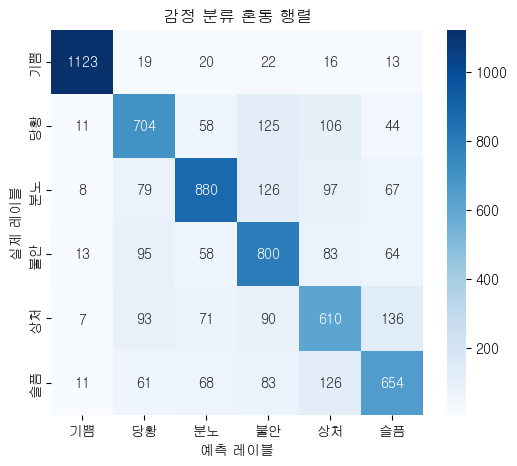

In [48]:
import matplotlib.pyplot as plt           # 기본 플롯팅(그래프) 라이브러리
import seaborn as sns                     # 통계적 데이터 시각화용 라이브러리
import matplotlib.font_manager as fm

# Seaborn 시각화의 경우, font_manager로 직접 추가해야 한글 시각화 가능

# GULIM.TTC 경로 지정 (./data/GULIM.TTC라면 그대로 사용)
font_path = "./data/GULIM.TTC"
fm.fontManager.addfont(font_path)

# FontProperties를 통해 실제 패밀리 이름 가져오기
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()    # 예: 'Gulim'

# matplotlib 전역 설정에 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 3.3) matplotlib으로 그래프 크기 설정 후 seaborn heatmap으로 시각화
plt.figure(figsize=(6, 5))              # (가로, 세로) 크기 지정 (인치 단위)
sns.heatmap(
    cm,                                 # 그릴 행렬 데이터
    annot = True,                       # 셀 안에 숫자 표기 여부
    fmt = "d",                          # 숫자 형식: 정수(decimal)
    cmap = "Blues",                     # 컬러맵: 블루 계열
    xticklabels = id_to_label.values(), # x축 눈금 레이블: 예측 클래스 이름
    yticklabels = id_to_label.values()  # y축 눈금 레이블: 실제 클래스 이름
)
plt.xlabel("예측 레이블")                # x축 제목
plt.ylabel("실제 레이블")                # y축 제목
plt.title("감정 분류 혼동 행렬")         # 그래프 제목
plt.show()                               # 화면에 플롯 출력

In [ ]:
# 모델 감성 분석 예측, 성능 자체 나쁘지는 않지만
# 부정적인 감정선 안에서는 카테고리 분류가 명확하지 않은 것도 사실
# 부정적인 감정이 분류가 어려운 이유는 비슷한 단어를 가진 문장이 많았을 것

-4. HuggingFace Pipeline을 이용한 감정 분류 모델 추론 (inference) 세팅

In [49]:
from transformers import pipeline
# 텍스트 분류용(감정 분류) 파이프라인 생성
emotion_classifier = pipeline(
    task = "text-classification", # 감정 분류 문제 해결
    model = sent_trainer.model,   # 학습된 모델 객체 연결
    tokenizer = tokenizer_k,                 # 모델에 맞는 토크나이저 연결
    top_k = 1                     # 최고 점수 예측한 정보 1개만 반환 (None으로 설정하면, 모든 클래스 점수 변환)
)

Device set to use cuda:0


In [50]:
# 예시 문장 리스트
example_sentences = [
    "와 오늘 새로 산 아이폰이 정말 최고예요! 디자인도 예쁘고 성능도 마음에 들어요.",
    "회사 면접 결과를 기다리고 있는데 너무 불안하고 걱정돼.",
    "친구가 약속을 몇 번이나 어겨서 정말 화가 난다.",
    "열심히 준비한 발표에서 실수해서 많이 당황스럽고 속상해.",
]

In [51]:
emotion_classifier(example_sentences[0])

[[{'label': 'LABEL_0', 'score': 0.9964169263839722}]]

In [54]:
# 파이프라인으로 문장별 감정 예측 및 결과 출력

for sent in example_sentences:
  pred = emotion_classifier(sent)[0][0]

  print(f"""
      - 문장: {sent}
        -> 예측 감성: {pred['label']}, (sore = {pred['score']})
  """)


      - 문장: 와 오늘 새로 산 아이폰이 정말 최고예요! 디자인도 예쁘고 성능도 마음에 들어요.
        -> 예측 감성: LABEL_0, (sore = 0.9964169263839722)
  

      - 문장: 회사 면접 결과를 기다리고 있는데 너무 불안하고 걱정돼.
        -> 예측 감성: LABEL_3, (sore = 0.9420440196990967)
  

      - 문장: 친구가 약속을 몇 번이나 어겨서 정말 화가 난다.
        -> 예측 감성: LABEL_2, (sore = 0.9216888546943665)
  

      - 문장: 열심히 준비한 발표에서 실수해서 많이 당황스럽고 속상해.
        -> 예측 감성: LABEL_1, (sore = 0.6612036824226379)
  


## 2.2NER(개체명 인식) 모델 fine tuning

In [55]:
# 모델/ 토크나이저 로드 (위 분류 모델과 동일한 모델로 설정할 예정, 가독성을 위해 한 번 더 설정)
ner_model_name_k = 'monologg/koelectra-base-v3-discriminator'
ner_tokenizer_k = AutoTokenizer.from_pretrained(ner_model_name_k) # tokenizer_k

In [56]:
# 답 클래스 개념 정의
# 불러올 때, 몇 개의 클래스를 구분해야하는지 전달
num_ner_labels = len(tag_to_id)
num_ner_labels

29

In [57]:
# ner 모델을 로드하는 클래스
from transformers import AutoModelForTokenClassification

In [58]:
# 사전학습 모델의 가중치, 토큰 분류 헤드 클래스 개수를 연결
# 모델 정의
ner_model_k = AutoModelForTokenClassification.from_pretrained(
    ner_model_name_k,
    num_labels = num_ner_labels
)

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
ner_model_k.config.id2label = id_to_tag
ner_model_k.config.label2id = tag_to_id

print(ner_model_k.config.id2label)
print(ner_model_k.config.label2id)

{0: 'B-AFW', 1: 'I-AFW', 2: 'B-ANM', 3: 'I-ANM', 4: 'B-CVL', 5: 'I-CVL', 6: 'B-DAT', 7: 'I-DAT', 8: 'B-EVT', 9: 'I-EVT', 10: 'B-FLD', 11: 'I-FLD', 12: 'B-LOC', 13: 'I-LOC', 14: 'B-MAT', 15: 'I-MAT', 16: 'B-NUM', 17: 'I-NUM', 18: 'O', 19: 'B-ORG', 20: 'I-ORG', 21: 'B-PER', 22: 'I-PER', 23: 'B-PLT', 24: 'I-PLT', 25: 'B-TIM', 26: 'I-TIM', 27: 'B-TRM', 28: 'I-TRM'}
{'B-AFW': 0, 'I-AFW': 1, 'B-ANM': 2, 'I-ANM': 3, 'B-CVL': 4, 'I-CVL': 5, 'B-DAT': 6, 'I-DAT': 7, 'B-EVT': 8, 'I-EVT': 9, 'B-FLD': 10, 'I-FLD': 11, 'B-LOC': 12, 'I-LOC': 13, 'B-MAT': 14, 'I-MAT': 15, 'B-NUM': 16, 'I-NUM': 17, 'O': 18, 'B-ORG': 19, 'I-ORG': 20, 'B-PER': 21, 'I-PER': 22, 'B-PLT': 23, 'I-PLT': 24, 'B-TIM': 25, 'I-TIM': 26, 'B-TRM': 27, 'I-TRM': 28}


In [60]:
# 학습 세부 사항 조정
batch_size = 32
# 메모리 사용량 줄이기 위해 최소화로 배치사이즈 설정

training_args = TrainingArguments(
    output_dir = './data/ner_model_k',     # 학습 결과(모델 가중치, 체크포인트 등)을 저장할 디렉토리
    num_train_epochs = 3,                   # 학습할 에포크(Epoch) 수, 전체 데이터셋을 몇 번 반복하여 학습할지를 설정함
    per_device_train_batch_size = batch_size, # 학습 시 사용될 배치 크기
    learning_rate = 5e-5,                    # 학습률 (5e-5=0.00005 : BERT계열 모델에 흔히 쓰이는 값)
    eval_strategy = 'epoch',                 # 이벨류에이션 스트레이트지(검증 전략), "epoch"로 하면 각 epoch 끝날 때 검증
    logging_steps = 500,                       # 학습 중간에 로그를 찍는 간격 (스텝 수)
    save_strategy = 'epoch',                  # 모델 저장 전략 (여기서는 epoch마다 저장)
    load_best_model_at_end = True,          # True : 검증 성능이 최고인 체크포인트를 마지막에 불러옴
    metric_for_best_model = "f1",           # 최고 모델 판단에 사용할 메트릭 ("accuracy"으로 지정)
    push_to_hub = False,                    # 학습 후 수동으로 push 예정
    report_to = 'none'                   # W&B 비활성화 (W&B 연동 시, 로그를 남기기 위해 API 키 인증을 요구하므로 none 설정)
                                         # 24년 10월 경부터 Trainer에 기본값으로 W&B(Weights & Biases)에 실험(run)을 기록하도록 설정되어 있음
)

In [61]:
# ner 평가지표 정의
from seqeval.metrics import f1_score as ner_f1_score
def compute_ner_metrics(pred):
    """
    Trainer.predict() 결과(pred)를 받아 NER용 F1 점수를 계산
    입력 pred:
      - pred.predictions: 모델 출력 logits (배치_size × seq_len × num_labels)
      - pred.label_ids: 실제 레이블 ID 배열 (배치_size × seq_len)
    동작:
      1. logits에서 가장 높은 값의 인덱스를 예측 레이블로 선택
      2. -100(ignored index)이 아닌 위치만 골라 태그 문자열로 변환
      3. true_tags, pred_tags 리스트 생성 (문장 단위 태그 시퀀스)
      4. seqeval의 f1_score로 전체 F1 점수 계산
    반환:
      - {"f1": float} 형태의 딕셔너리
    """
    logits = pred.predictions
    labels = pred.label_ids

    # 각 토큰 위치에서 가장 높은 로짓을 가진 클래스 인덱스로 예측
    preds = np.argmax(logits, axis=-1)

    true_tags, pred_tags = [], []
    # 배치의 각 문장별로
    for lb_seq, pr_seq in zip(labels, preds):
        t_seq, p_seq = [], []
        # 토큰 단위로
        for true_id, pred_id in zip(lb_seq, pr_seq):
            if true_id == -100:
                # -100: 패딩 또는 special token 위치 → 무시
                continue
            # ID → 태그 문자열로 변환
            t_seq.append(id_to_tag[true_id])
            p_seq.append(id_to_tag[pred_id])
        true_tags.append(t_seq)
        pred_tags.append(p_seq)

    # seqeval의 f1_score 사용
    return {"f1": ner_f1_score(true_tags, pred_tags)}

In [62]:
# ner datacollator 정의

from transformers import DataCollatorForTokenClassification

In [64]:
data_collator_k = DataCollatorForTokenClassification(tokenizer = ner_tokenizer_k)

In [67]:
# Trainer 객체 정의
ner_trainer = Trainer(
    model = ner_model_k,   # 학습 모델 연결
    args = training_args, # 위에서 정의한 학습 설정
    train_dataset = ner_train_ds, # 학습 데이터셋(Dataset 객체)
    eval_dataset = ner_val_ds,    # 검증 데이터셋 연결
    data_collator = data_collator_k, # 배치 단위로 데이터 묶기 실행하는 객체
    processing_class = ner_tokenizer_k,
    compute_metrics = compute_ner_metrics # 검증 시 호출할 평가지표 함수 (f1)
)

In [68]:
# ner 학습
# A100 - 분
ner_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.277600,0.245100,0.794787
2,0.196100,0.216012,0.823075
3,0.139300,0.216193,0.829686


TrainOutput(global_step=6330, training_loss=0.24657671658725347, metrics={'train_runtime': 914.8997, 'train_samples_per_second': 221.336, 'train_steps_per_second': 6.919, 'total_flos': 9307975866497616.0, 'train_loss': 0.24657671658725347, 'epoch': 3.0})

- 5. Hugging Face Pipeline을 이용하여 개체명 인식 모델 추론 세팅

In [69]:
ner_pipe = pipeline(
    task = "ner", # 개체명 인식 과제 지정
    model = ner_trainer.model, # 앞서 학습한 모델 사용
    tokenizer = ner_tokenizer_k,
    aggregation_strategy = "simple" # sub_token 단위로 분할된 개체를 간단히 합쳐서 하나의 엔티티로 묶어줌
)

Device set to use cuda:0


In [70]:
# 2) 예시 문장 리스트: 브랜드나 제품명 같은 ORG/PROD/ART 엔티티 추출해 보기
example_texts = [
    "삼성전자 신제품 스마트폰 갤럭시S22가 출시되었다.",
    "어제 스타벅스에서 커피를 마셨는데 신메뉴가 정말 맛있었어.",
    "나는 LG OLED TV를 사고 싶다.",
    "쿠팡에서 주문한 물건이 일주일째 안 와서 화가 난다."
]

### 태그 코드별 의미

- B-XXX: 엔티티(Entity)의 시작 토큰
- I-XXX: 동일 엔티티 내부의 계속 토큰
- O : 어떤 엔티티에도 속하지 않는 토큰

| 태그 코드 | 설명 (한글)           | 설명 (영문)       |
| :---: | :---------------- | :------------ |
|  AFW  | 인공물               | Artifact      |
|  ANM  | 동물                | Animal        |
|  CVL  | 시설물·교통수단          | Civil/Vehicle |
|  DAT  | 날짜                | Date          |
|  EVT  | 사건·행사             | Event         |
|  FLD  | 분야·학문             | Field         |
|  LOC  | 장소·위치             | Location      |
|  MAT  | 재료·소재             | Material      |
|  NUM  | 숫자·수량             | Number        |
|  ORG  | 기관·단체             | Organization  |
|  PER  | 인물                | Person        |
|  PLT  | 식물                | Plant         |
|  TIM  | 시간                | Time          |
|  TRM  | 용어·개념             | Term          |
| **O** | 태그 대상 아님(Outside) | Outside       |

In [72]:
# 문장 1개 예측해보기
ner_pipe(example_texts[0])

[{'entity_group': 'ORG',
  'score': np.float32(0.98713624),
  'word': '삼성전자',
  'start': 0,
  'end': 4},
 {'entity_group': 'TRM',
  'score': np.float32(0.7710591),
  'word': '스마트폰',
  'start': 9,
  'end': 13},
 {'entity_group': 'TRM',
  'score': np.float32(0.98066664),
  'word': '갤럭시S22가',
  'start': 14,
  'end': 21}]

In [73]:
# 각 문장마다 NER 수행하고, ORG(조직), PROD(제품), ART(인공물) 태그 필터링
for text in example_texts:
    ents = ner_pipe(text)
    print(f"문장: {text}")
    if ents :
        # ents: [{'entity_group':'ORG','score':0.99,'word':'삼성전자',...}, ...]
        brands = [
            ent['word']
            for ent in ents
            if ent['entity_group'].endswith("ORG") # 끝 문자열이 지정된 문자와 같은지 True / False 형식(bool)으로 반환
            or ent['entity_group'].endswith("PROD")
            or ent['entity_group'].endswith("ART")
        ]
        print("  추출된 브랜드/제품명:", brands)
    else:
        print("  추출된 브랜드/제품명: 없음")

문장: 삼성전자 신제품 스마트폰 갤럭시S22가 출시되었다.
  추출된 브랜드/제품명: ['삼성전자']
문장: 어제 스타벅스에서 커피를 마셨는데 신메뉴가 정말 맛있었어.
  추출된 브랜드/제품명: ['스타벅스에서']
문장: 나는 LG OLED TV를 사고 싶다.
  추출된 브랜드/제품명: ['LG']
문장: 쿠팡에서 주문한 물건이 일주일째 안 와서 화가 난다.
  추출된 브랜드/제품명: ['쿠팡에서']


## 6.브랜드추출+감정 분류 활용
- 븐랜드 언급 및 감정 결과 통합 리포트

In [74]:
# 소셜 미디어 게시글 예시: 브랜드 언급과 감정(긍정/부정) 분석 결합
social_posts = [
    "아이폰14 프로를 드디어 샀는데, 성능이 너무 좋아서 기분이 최고다!",
    "스타벅스 신메뉴 음료 마셔봤는데 너무 별로라서 슬프네...",
    "쿠팡에서 또 배송 문제가 생겨서 정말 짜증난다.",
    "LG 세탁기가 고장나서 수리받았는데도 계속 오류가 떠서 불안하다.",
    "맛집이라고 해서 갔는데 파리바게뜨 케이크 맛없어서 상처받았어요."
]

In [76]:
# 감정, 제품명/브랜드명에 대한 예측 결과를 담을 리스트 선언
analysis_results = []

# 소셜 댓글을 반복시키며, 2개의 학습된 모델을 연결(추론, 예측)
for post in social_posts:
  # post: 문자열
  # 1) 브랜드/제품명 추출 - ner_pipe
  ents = ner_pipe(post)
  brands = [ent['word'] for ent in ents] # 모든 추출된 entity 단어 리스트

  # 2) 감정 분류 모델 - emotion_classifier
  emotion = emotion_classifier(post)[0][0]['label'] # emotion <- LABEL_0

  # - 감정 예측 결과(정답 데이터 int 로 추출 )
  label_idx = int(emotion.split('_')[1]) # label_idx <- 0

  # - int -> 문자
  emotion_str = id_to_label[label_idx] # label_idx : 0~5

  # 3) analysis_results 변수에 2개의 결과를 저장 : (브랜드 리스트, 감정 레이블)
  analysis_results.append((brands, emotion_str))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [78]:
# 4) 최종 출력
# 문장 + 추론 결과

for post, (brands, emotion) in zip(social_posts, analysis_results):
  print(f"문장: {post}\n -> 브랜드: {brands}, 감정: {emotion}\n")

문장: 아이폰14 프로를 드디어 샀는데, 성능이 너무 좋아서 기분이 최고다!
 -> 브랜드: ['아이폰14 프로를'], 감정: 기쁨

문장: 스타벅스 신메뉴 음료 마셔봤는데 너무 별로라서 슬프네...
 -> 브랜드: ['스타벅스'], 감정: 슬픔

문장: 쿠팡에서 또 배송 문제가 생겨서 정말 짜증난다.
 -> 브랜드: ['쿠팡에서'], 감정: 분노

문장: LG 세탁기가 고장나서 수리받았는데도 계속 오류가 떠서 불안하다.
 -> 브랜드: ['LG', '세탁기가'], 감정: 불안

문장: 맛집이라고 해서 갔는데 파리바게뜨 케이크 맛없어서 상처받았어요.
 -> 브랜드: ['파리바게뜨'], 감정: 상처



- 브랜드별 감정 빈도를 집계하고 시각화해볼 수도 있음
- 실제로 더 많은 데이터를 수집했다면 한 브랜드가 여러 감정의 언급을 받을 것이므로, 여기서는 임의로 몇 가지 브랜드에 대한 감정 분포를 가정해 시각화 시도가 가능해짐
    ```
    예를 들어,
    스타벅스 관련 게시글 12건 중 기쁨 5건, 슬픔 2건, 분노 3건, 당황 1건, 불안 1건, 상처 0건이었다고 하고,
    아이폰 관련 12건 중 기쁨 4건, 슬픔 1건, 분노 4건, 당황 0건, 불안 2건, 상처 1건,
    쿠팡 관련 12건 중 기쁨 2건, 슬픔 1건, 분노 5건, 당황 0건, 불안 3건, 상처 0건
    ```
- 감정 통계 시각화를 통해 각 브랜드에 대한 여론의 감정적 성격을 한눈에 파악할 수 있음
- 실제 응용에서는 브랜드 마케팅 또는 고객 관리 관점에서, 긍정적인 감정을 유발하는 요인과 부정적인 감정을 유발하는 요인을 분석하여 전략을 수립하는 데 활용해볼 수 있음